In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 4.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import LeaveOneOut
import os
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
import math
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
from imblearn.over_sampling import SMOTE
#import shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def xgb_custom_loss(y_true, y_pred, train_data_df, minority_class_weight):
    if isinstance(y_pred, xgb.core.DMatrix):
      y_pred = y_pred.get_label()
    y_pred_prob = 1 / (1 + np.exp(-y_pred))
    train_data_df = pd.DataFrame(train_data_df)
    class_weights = np.where(y_true == 1, minority_class_weight, 1)
    gradient = class_weights * (y_pred_prob - y_true)
    hessian = class_weights * y_pred_prob * (1 - y_pred_prob)
    return gradient, hessian

def xgb_custom_obj(train_data_df,ratio):
    def custom_obj(y_true, y_pred):
        minority_class_weight = ratio
        gradient, hessian = xgb_custom_loss(y_true, y_pred, train_data_df, minority_class_weight)
        return gradient, hessian
    return custom_obj

In [ ]:
step = ['fitbit_steps_intraday_rapids_stdsteps', 'fitbit_steps_intraday_rapids_minsteps', 'fitbit_steps_intraday_rapids_mindurationactivebout', 'fitbit_steps_intraday_rapids_sumsteps', 'fitbit_steps_intraday_rapids_avgdurationactivebout', 'fitbit_steps_intraday_rapids_maxdurationactivebout', 'fitbit_steps_intraday_rapids_countepisodesedentarybout', 'fitbit_steps_intraday_rapids_stddurationsedentarybout', 'fitbit_steps_intraday_rapids_maxsteps', 'fitbit_steps_intraday_rapids_avgsteps', 'fitbit_steps_intraday_rapids_countepisodeactivebout', 'fitbit_steps_intraday_rapids_maxdurationsedentarybout', 'fitbit_steps_intraday_rapids_sumdurationactivebout', 'fitbit_steps_intraday_rapids_sumdurationsedentarybout', 'fitbit_steps_intraday_rapids_mindurationsedentarybout', 'fitbit_steps_intraday_rapids_avgdurationsedentarybout']
heartrate = ['fitbit_heartrate_intraday_rapids_modehr', 'fitbit_heartrate_intraday_rapids_stdhr', 'fitbit_heartrate_intraday_rapids_avghr', 'fitbit_heartrate_intraday_rapids_minutesonfatburnzone', 'fitbit_heartrate_intraday_rapids_minhr', 'fitbit_heartrate_intraday_rapids_entropyhr', 'fitbit_heartrate_intraday_rapids_maxhr', 'fitbit_heartrate_intraday_rapids_minutesoncardiozone', 'fitbit_heartrate_intraday_rapids_medianhr', 'fitbit_heartrate_intraday_rapids_diffminmodehr', 'fitbit_heartrate_intraday_rapids_minutesonoutofrangezone', 'fitbit_heartrate_intraday_rapids_diffmaxmodehr', 'fitbit_heartrate_intraday_rapids_minutesonpeakzone']
screen = ['phone_screen_rapids_sumdurationunlock', 'phone_screen_rapids_countepisodeunlock', 'phone_screen_rapids_firstuseafter00unlock', 'phone_screen_rapids_mindurationunlock', 'phone_screen_rapids_maxdurationunlock', 'phone_screen_rapids_avgdurationunlock']
location = ['phone_locations_doryab_avgspeed', 'phone_locations_doryab_numberofsignificantplaces', 'phone_locations_doryab_maxlengthstayatclusters', 'phone_locations_doryab_homelabel', 'phone_locations_doryab_loglocationvariance', 'phone_locations_doryab_totaldistance', 'phone_locations_doryab_locationvariance', 'phone_locations_doryab_radiusgyration', 'phone_locations_doryab_locationentropy', 'phone_locations_doryab_movingtostaticratio', 'phone_locations_doryab_avglengthstayatclusters', 'phone_locations_doryab_timeattop3location', 'phone_locations_doryab_minlengthstayatclusters', 'phone_locations_doryab_timeattop1location', 'phone_locations_doryab_timeattop2location', 'phone_locations_doryab_stdlengthstayatclusters', 'phone_locations_doryab_numberlocationtransitions', 'phone_locations_doryab_normalizedlocationentropy']
wifi = ['phone_wifi_visible_rapids_countscansmostuniquedevice', 'phone_wifi_visible_rapids_uniquedevices', 'phone_wifi_visible_rapids_countscans']
battery = ['phone_battery_rapids_countdischarge', 'phone_battery_rapids_sumdurationdischarge', 'phone_battery_rapids_sumdurationcharge', 'phone_battery_rapids_maxconsumptionrate', 'phone_battery_rapids_countcharge', 'phone_battery_rapids_avgconsumptionrate']
print(len(step),len(heartrate),len(screen),len(location),len(wifi),len(battery))

16 13 6 18 3 6


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Stress/data.csv')
pids = df['pid'].unique()
print(len(pids))

60


In [ ]:
com = [heartrate+step+wifi+location+battery]

In [ ]:
# feature_ranks = pd.DataFrame(columns=df.columns)
#shap_values_df = pd.DataFrame(columns=df.columns)
for a in range(len(com)):
  print('the combination is', a)
  auc_list = []

  loo = LeaveOneOut()
  for pid in pids:
    print(pid)
    participant_data = df[df['pid'] == pid]
    participant_data = participant_data.dropna(axis=1, how='all')

    X = participant_data.drop(['pid', 'label'], axis=1)
    X = X[com[a]]
    y = participant_data['label']

    if np.sum(participant_data['label'] == 1) <= 4:
        print('Skip Participants: ', pid)
        continue

    auc_scores = []
    y_real = []
    y_prob = []

    # feature_importances_list = []
    #shap_values_list = []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        n_minority_samples = np.sum(y_train == 1)
        n_majority_samples = np.sum(y_train == 0)
        if n_minority_samples <= 3:
            print('Skip this Sample')
            continue
        ratio = round(n_majority_samples / n_minority_samples)

        clf = XGBClassifier(random_state=42,objective=xgb_custom_obj(X, ratio))
        clf.fit(X_train, y_train)

        # importance_df = pd.DataFrame(clf.feature_importances_, index=X.columns, columns=['importance'])
        # importance_df.sort_values(by='importance', ascending=False, inplace=True)
        # feature_importances_list.append(importance_df['importance'].values)

        #explainer = shap.Explainer(clf)
        #shap_values = explainer.shap_values(X_test)
        #print(shap_values)
        #print(shap_values[0])
        #shap_values_list.append(shap_values[1])

        y_pred = clf.predict_proba(X_test)[:, 1]
        y_real.append(y_test)
        y_prob.append(y_pred)

    #     threshold = 0.5
    #     y_pred = np.where(y_pred[0] > threshold, 1, 0)
    #     y_prob.append(y_pred)

    auc_score = roc_auc_score(y_real, y_prob)
    print(auc_score)
    auc_list.append(auc_score)
  print(np.mean(auc_list))

    #f1 = f1_score(y_real, y_prob, pos_label=1)
    #print(f1)
    #recall = recall_score(y_real, y_prob, pos_label=1)
    #print(recall)
    #precision = precision_score(y_real, y_prob, pos_label=1)
    #print(precision)

    #average_feature_importances = np.mean(feature_importances_list, axis=0)
    #ranks = np.argsort(average_feature_importances)[::-1] + 1
    #feature_ranks.loc[pid, importance_df.index] = ranks


    #average_shap_values = np.mean(shap_values_list, axis=0)
    #shap_values_df.loc[pid, X.columns] = average_shap_values

    # shap_values_df.loc[pid, 'AUC'] = auc_score
    # shap_values_df.loc[pid, 'Precision'] = precision
    # shap_values_df.loc[pid, 'F1'] = f1
    # shap_values_df.loc[pid, 'Recall'] = recall

    #feature_ranks.to_csv('/content/drive/MyDrive/Stress/Rank.csv')
    #shap_values_df.to_csv('/content/drive/MyDrive/Stress/SHAP.csv')

the combination is 0
p205
0.7794682895579756
p241
0.7373004354136429
p255
0.6098731043020736
p256
0.648614697466676
p260
0.6604672057502246
p269
0.7893372224923028
p272
0.8299516908212561
p274
0.7520271266401297
p276
0.6337962962962962
p281
0.546224623922886
p282
0.726245744351594
p285
0.5902876420454546
p289
0.7689935064935065
p291
0.6337243837243838
p292
0.596125730994152
p293
0.8145674300254453
p295
0.7777777777777777
p298
0.6717850287907868
p307
0.726790750141004
p308
0.7220081942151287
p311
0.746536482385539
p312
0.8462962962962963
p313
0.8064846696179702
p314
0.6137422360248447
p319
0.7673391701560716
p321
0.7172316384180791
p322
0.7071000065923925
p323
0.8076923076923078
p324
0.7602533023301835
p325
0.48450543167524307
p330
0.6595454545454547
p331
0.6499805068226121
p333
0.6740827748220825
p334
0.8464344941956882
p337
0.7375018543242843
p338
0.6539382152741416
p339
0.5124241668744286
p343
0.7012522361359571
p345
0.7150228387751649
p347
0.8115278040178852
p349
0.7549194991055457


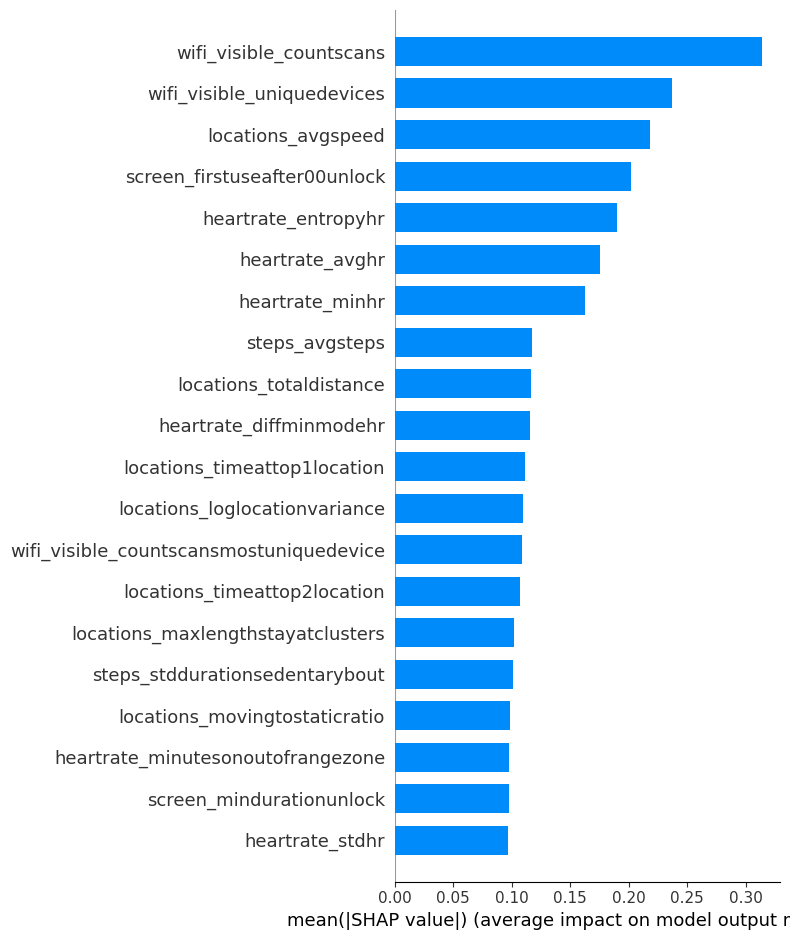

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Stress/data.csv')
remove_list = ['doryab_','intraday_','rapids_','phone_','fitbit_']
for r in remove_list:
    df.columns = [col.replace(r, '') for col in df.columns]

shap_values_df = pd.DataFrame(columns=df.columns)

X = df.drop(['pid', 'label'], axis=1)
y = df['label']

n_minority_samples = np.sum(y == 1)
n_majority_samples = np.sum(y == 0)
ratio = round(n_majority_samples / n_minority_samples)

clf = XGBClassifier(random_state=42, objective=xgb_custom_obj(X, ratio))
clf.fit(X, y)

explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X, plot_type="bar")